In [1]:
import pandas as pd
import numpy as np
import os
from os.path import join, pardir
DATA_DIR = join(pardir, pardir, 'data', 'write_new_algorithm')
DATA_DIR_ZK = join(pardir, pardir, 'data', 'write_zookeeper')

dfs = []
dfs2 = []
for mem in [512, 1024, 2048]:
    
    for size in [4, 1024, 65536, 131072, 256000]:
        df = pd.read_csv(join(DATA_DIR, f'persistent_{size}_{mem}_processed.csv'), index_col=0)
        df['size'] = size / 1024
        
        #print(df)
        # data is broken :-(
        #df = df.loc[df['memory'] == mem]
        #df = df.groupby(['memory', 'function']).head(150).reset_index(drop=True)
        #if df.shape[0] > 200:
        #    print(size, mem)
        dfs.append(df)
        
        
        zk = pd.read_csv(join(DATA_DIR, f'persistent_{size}_{mem}_processed.csv'), index_col=0)
        
        
        df = pd.read_csv(join(DATA_DIR, f'persistent_{size}_{mem}.csv'), index_col=0)
        #df = df.groupby(['memory', 'size']).head(100).reset_index(drop=True)
        df['size'] = size / 1024
        df['data'] /= 1000.0
        #df.loc[df['op'] == 'set_data', 'data'] /= 1000
        dfs2.append(df)

for size in [4, 1024, 65536, 131072, 256000]:
    df = pd.read_csv(join(DATA_DIR_ZK, f'interregion_{size}.csv'), index_col=0)
    df['data'] /= 1000.0
    df['size'] /= 1024.0
    df['memory'] = 'ZooKeeper'
    dfs2.append(df)

        
dynamo_df = pd.concat(dfs)
dynamo_df['system'] = 'persistent'
dynamo_df_client = pd.concat(dfs2)
dynamo_df_client['system'] = 'persistent'
print(dynamo_df_client.loc[dynamo_df_client['memory'] == 'ZooKeeper'])
print(dynamo_df)



       data  client_write_data        op     memory        size      system
0     4.074                NaN  set_data  ZooKeeper    0.003906  persistent
1     4.041                NaN  set_data  ZooKeeper    0.003906  persistent
2     3.772                NaN  set_data  ZooKeeper    0.003906  persistent
3     3.598                NaN  set_data  ZooKeeper    0.003906  persistent
4     3.351                NaN  set_data  ZooKeeper    0.003906  persistent
..      ...                ...       ...        ...         ...         ...
145  34.913                NaN  set_data  ZooKeeper  250.000000  persistent
146   9.084                NaN  set_data  ZooKeeper  250.000000  persistent
147  34.226                NaN  set_data  ZooKeeper  250.000000  persistent
148   9.794                NaN  set_data  ZooKeeper  250.000000  persistent
149  57.683                NaN  set_data  ZooKeeper  250.000000  persistent

[750 rows x 6 columns]
                                   request     time  billed_time

## Figure 9 - Write distribution on AWS

In [2]:
DATA_DIR = join(pardir, pardir, 'data', 'write_new_algorithm')
dfs = []
import ast
# lock atomic commit push rest
#barplot_data = [[],[],[],[],[]]
#barplot_stds = [[],[],[],[],[],[]]
#for size in [4, 1024, 65536, 131072, 256000]:


full_data = []
for size in [4, 1024, 65536, 131072, 256000]:
    
    for memory in [512, 1024, 2048]:
    #for memory in [512]:
        
        with open(join(DATA_DIR, f'persistent_{size}_{memory}.timings')) as in_f:
                  
            writer = False
            for line in in_f:
                
                #print(line.split(':')[2])
                key = line.split(':')[1].split()[0].strip()
                if key == 'total':
                    key = f'{key}_writer' if not writer else f'{key}_distributor'
                    writer = True
                data = ast.literal_eval(line.split(':')[2])
                for val in data:
                    full_data.append([int(size), int(memory), key, val])
        

timings_df = pd.DataFrame(data=full_data, columns=['size', 'memory', 'key', 'value']) 
timings_df['value'] *= 1000
print(timings_df['key'].unique())
#size = 4
#memory = 512
#df = pd.read_csv(join(DATA_DIR, f'persistent_{size}_summary.csv'),index_col=None)
#df['size'] = size / 1024.0
#df['value'] *= 1000.0
#df['value'] /= df['repetitions']
#print(df.loc[(df['memory'] == memory) & (df['function'] == 'writer')])

#barplot_data[0].append(df.loc[(df['memory'] == memory) & (df['function'] == 'writer') & (df['type'] == 'lock')]['value'].values[0])
#barplot_data[1].append(df.loc[(df['memory'] == memory) & (df['function'] == 'writer') & (df['type'] == 'atomic')]['value'].values[0])
#barplot_data[2].append(df.loc[(df['memory'] == memory) & (df['function'] == 'writer') & (df['type'] == 'commit')]['value'].values[0])
#barplot_data[3].append(df.loc[(df['memory'] == memory) & (df['function'] == 'writer') & (df['type'] == 'push')]['value'].values[0])
#total = df.loc[(df['memory'] == memory) & (df['function'] == 'writer') & (df['type'] == 'total')]['value'].values[0]
#barplot_data[4].append(
#    total
#    - barplot_data[0][-1] - barplot_data[1][-1] - barplot_data[2][-1] - barplot_data[3][-1]
#)
barplot_data_writer = [[],[],[],[]]


for size in [4, 65536, 256000]:
    
    for memory in [512, 2048]:
        
        barplot_data_writer[0].append(
            timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'lock')]['value'].median()
        )
        barplot_data_writer[1].append(timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size)& (timings_df['key'] == 'commit')]['value'].median())
        barplot_data_writer[2].append(timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size)& (timings_df['key'] == 'push')]['value'].median())

        total = timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size)& (timings_df['key'] == 'total_writer')]['value'].median()
        #print(total)
        barplot_data_writer[3].append(
            total
            - barplot_data_writer[0][-1] - barplot_data_writer[1][-1] - barplot_data_writer[2][-1]
        )
        
barplot_data_distributor = [[],[],[],[],[]]


for size in [4, 65536, 256000]:
    
    for memory in [512, 2048]:
        
        barplot_data_distributor[0].append(
            timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'exec_read')]['value'].median()
            + timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'exec_update')]['value'].median()
        )
        #barplot_data_distributor[1].append(
        #    timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'exec_update')]['value'].median()
        #)
        barplot_data_distributor[1].append(
            timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'exec_pop_updates')]['value'].median()
        )
        barplot_data_distributor[2].append(timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size)& (timings_df['key'] == 'watch_query')]['value'].median())
        barplot_data_distributor[3].append(timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size)& (timings_df['key'] == 'notify')]['value'].median())

        total = timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size)& (timings_df['key'] == 'total_distributor')]['value'].median()
        #print(total)
        barplot_data_distributor[4].append(
            total
            - barplot_data_distributor[0][-1] - barplot_data_distributor[1][-1] - barplot_data_distributor[2][-1] - barplot_data_distributor[3][-1]
        )

['lock' 'push' 'commit' 'total_writer' 'parse' 'write' 'watch_query'
 'notify' 'watch_notify' 'total_distributor' 'exec_read' 'exec_update'
 'exec_pop_updates']


[9.252190589904785, 8.016109466552734, 7.154583930969238, 7.843971252441406, 9.09268856048584, 8.359432220458984]
[8.596658706665039, 7.932901382446289, 7.121801376342773, 7.674574851989746, 7.555723190307617, 8.585929870605469]
[13.515353202819824, 13.349533081054688, 52.80601978302002, 27.72808074951172, 189.34237957000732, 72.18217849731445]
[1.1459589004516602, 0.5167722702026367, 0.6235837936401367, 0.662684440612793, 5.452752113342285, 1.6455650329589844]


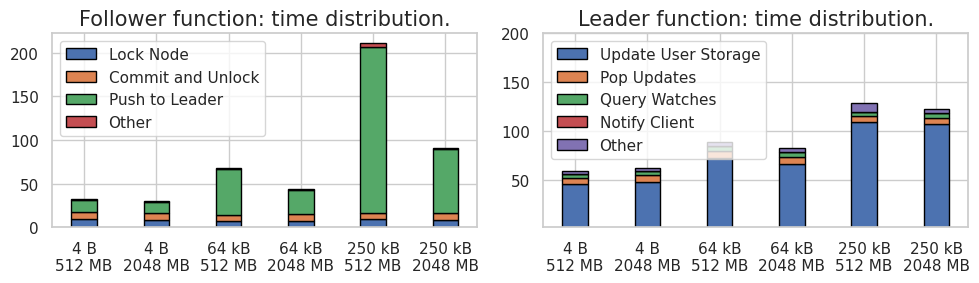

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from scipy import stats
from os.path import join, pardir
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

DATA_DIR = join(pardir, pardir, 'data', 'read')

#sns.set(rc={'figure.figsize':(16,8)})
sns.set(rc={'figure.figsize':(10,3)})
sns.set_style("whitegrid")

fig3 = plt.figure(constrained_layout=True)
gs = fig3.add_gridspec(1,4)
barplot = fig3.add_subplot(gs[0,0:2])
barplot_distr = fig3.add_subplot(gs[0,2:4])

width = 0.35       # the width of the bars: can also be len(x) sequence
sum_ = [0,0,0,0,0,0]
labels = ['4 B\n512 MB', '4 B\n2048 MB', '64 kB\n512 MB', '64 kB\n2048 MB', '250 kB\n512 MB', '250 kB\n2048 MB']
for id, col in enumerate(['Lock Node', 'Commit and Unlock', 'Push to Leader', 'Other']):

    print(barplot_data_writer[id])
    barplot.bar(labels, barplot_data_writer[id], width, label=col, bottom=sum_, edgecolor='black')
    sum_ = np.add(sum_, barplot_data_writer[id])
barplot.legend()

barplot.set_title('Follower function: time distribution.', fontsize=15)


width = 0.35       # the width of the bars: can also be len(x) sequence
sum_ = [0,0,0,0,0,0]
labels = ['4 B\n512 MB', '4 B\n2048 MB', '64 kB\n512 MB', '64 kB\n2048 MB', '250 kB\n512 MB', '250 kB\n2048 MB']
for id, col in enumerate(['Update User Storage', 'Pop Updates', 'Query Watches', 'Notify Client', 'Other']):

    #print(barplot_data[id])
    barplot_distr.bar(labels, barplot_data_distributor[id], width, label=col, bottom=sum_, edgecolor='black')
    sum_ = np.add(sum_, barplot_data_distributor[id])
barplot_distr.legend(loc='upper left')
barplot_distr.set_ylim(1, 200)

barplot_distr.set_title('Leader function: time distribution.', fontsize=15)

plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig("write_distribution_aws.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)

## Table 3 - Analysis of variability

In [4]:
DATA_DIR = join(pardir, pardir, 'data', 'write_new_algorithm')
dfs = []
import ast
# lock atomic commit push rest
#barplot_data = [[],[],[],[],[]]
#barplot_stds = [[],[],[],[],[],[]]
#for size in [4, 1024, 65536, 131072, 256000]:


full_data = []
for size in [4, 1024, 65536, 131072, 256000]:
    
    for memory in [512, 1024, 2048]:
    #for memory in [512]:
        
        with open(join(DATA_DIR, f'persistent_{size}_{memory}.timings')) as in_f:
                  
            writer = False
            for line in in_f:
                
                #print(line.split(':')[2])
                key = line.split(':')[1].split()[0].strip()
                if key == 'total':
                    key = f'{key}_writer' if not writer else f'{key}_distributor'
                    writer = True
                data = ast.literal_eval(line.split(':')[2])
                for val in data:
                    full_data.append([int(size), int(memory), key, val])
        

timings_df = pd.DataFrame(data=full_data, columns=['size', 'memory', 'key', 'value']) 
timings_df['value'] *= 1000

#### Follower, total

In [8]:
# compute the writer statistics

def get_data(series):
    
    return (
        series.min(),
        series.median(),
        series.quantile(0.9),
        series.quantile(0.95),
        series.quantile(0.99),
        series.max()
    )

for size in [4, 65536, 256000]:
    
    for memory in [2048]:
        
        d = get_data(dynamo_df.loc[(dynamo_df['memory'] == memory) & (dynamo_df['function'] == 'writer') & (dynamo_df['size'] == size/1024.0)]['time'])
        print(memory, ' & ', size, *[f' & {round(x, 2)}' for x in d])
        

2048  &  4  & 27.29  & 31.81  & 38.55  & 41.88  & 58.78  & 63.24
2048  &  65536  & 32.55  & 47.76  & 55.35  & 63.26  & 90.41  & 122.57
2048  &  256000  & 30.24  & 102.53  & 142.35  & 163.15  & 183.49  & 223.17


#### Follower, distribution

In [17]:
# compute the writer statistics for detailed information

def get_data(series):
    
    return (
        series.min(),
        series.median(),
        series.quantile(0.9),
        series.quantile(0.95),
        series.quantile(0.99)
        #series.max()
    )

for size in [4, 256000]:
    
    for memory in [2048]:
        
        lock_data = get_data(
            timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'lock')]['value']
        )
        commit_data = get_data(
            timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'commit')]['value']
        )
        push_data = get_data(
            timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'push')]['value']
        )
        print(size, *[f' & {round(x, 2)}' for x in lock_data])
        print(size, *[f' & {round(x, 2)}' for x in push_data])
        print(size, *[f' & {round(x, 2)}' for x in commit_data])
        

4  & 7.38  & 8.02  & 9.47  & 12.69  & 26.8
4  & 9.65  & 13.35  & 15.55  & 17.28  & 38.15
4  & 7.31  & 7.93  & 9.41  & 11.91  & 26.83
256000  & 6.77  & 8.36  & 15.38  & 17.79  & 28.48
256000  & 62.73  & 72.18  & 96.82  & 118.62  & 148.61
256000  & 6.61  & 8.59  & 14.31  & 18.81  & 32.83


#### Leader, total

In [15]:
# compute the distributor statistics 

def get_data(series):
    
    return (
        series.min(),
        series.median(),
        series.quantile(0.9),
        series.quantile(0.95),
        series.quantile(0.99)
        #series.max()
    )

for size in [4, 256000]:
    
    for memory in [2048]:
        
        d = get_data(dynamo_df.loc[(dynamo_df['memory'] == memory) & (dynamo_df['function'] == 'distributor') & (dynamo_df['size'] == size/1024.0)]['time'])
        print(size, *[f' & {round(x, 2)}' for x in d])
        

4  & 42.02  & 62.16  & 92.01  & 103.65  & 138.28
256000  & 58.94  & 132.62  & 213.5  & 294.01  & 465.47


#### Leader, distribution

In [16]:
# compute the writer statistics for detailed information

def get_data(series):
    
    return (
        series.min(),
        series.median(),
        series.quantile(0.9),
        series.quantile(0.95),
        series.quantile(0.99)
    )

for size in [4, 256000]:
    
    for memory in [2048]:
        
        data = []
        
        lock_data = get_data(
            timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'exec_read')]['value']
        )
        commit_data = get_data(
            timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'exec_update')]['value']
        )
        push_data = get_data(
            timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'watch_query')]['value']
        )
        print(size, *[f' & {round(x, 2)}' for x in lock_data])
        print(size, *[f' & {round(x, 2)}' for x in commit_data])
        print(size, *[f' & {round(x, 2)}' for x in push_data])
        

4  & 4.67  & 5.09  & 5.68  & 6.92  & 11.83
4  & 24.4  & 42.73  & 70.7  & 84.94  & 118.13
4  & 3.88  & 4.48  & 5.45  & 7.0  & 28.64
256000  & 4.58  & 4.97  & 7.31  & 11.13  & 19.83
256000  & 32.51  & 102.07  & 183.17  & 265.42  & 432.92
256000  & 4.68  & 5.13  & 6.76  & 7.59  & 18.38


## Figure 8 - write performance with cost

#### Compute cost of write operations

In [18]:
import math
# PUT, COPY, POST, LIST requests (per 1,000 requests)
def write_s3(s):
    return  5*10**-6
def read_s3(s):
    return  0.4*10**-6
def write_dynamodb(s):
    return math.ceil(s) * 1.25 * 10**-6
def read_dynamodb(s):
    return math.ceil(s/4.0) * 0.25 * 10**-6
# FIFO Queues (per Million requests) 0.5
def sqs(s):
    return math.ceil(s/64.0) * 0.5 * 10**-6

lambda_const = 1.66667 * 10**-5

def writer(m, s):
    return lambda_const*(coefficients['writer'][m][0] * s + coefficients['writer'][m][1]) + 0.2 * 10**-6
def writer_time(m, s):
    return coefficients['writer'][m][0] * s + coefficients['writer'][m][1]
def distributor(m, s):
    return lambda_const*(coefficients['distributor'][m][0] * s + coefficients['distributor'][m][1]) + 0.2 * 10**-6
def distributor_time(m, s):
    return coefficients['distributor'][m][0] * s + coefficients['distributor'][m][1]

def total_cost(m, s):
    return 2 * sqs(s) + 3 * write_dynamodb(1) + read_dynamodb(1) + write_s3(s) + writer(m, s) + distributor(m, s)


In [19]:
import numpy as np
import pandas as pd
import os
from os.path import join, pardir
DATA_DIR = join(pardir, pardir, 'data', 'write_new_algorithm')

dfs = []
for mem in [512, 1024, 2048]:
    
    for size in [4, 1024, 65536, 131072, 256000]:
        df = pd.read_csv(join(DATA_DIR, f'persistent_{size}_{mem}_processed.csv'), index_col=0)
        df['size'] = size / 1024
        
        #print(df)
        # data is broken :-(
        #df = df.loc[df['memory'] == mem]
        #df = df.groupby(['memory', 'function']).head(150).reset_index(drop=True)
        #if df.shape[0] > 200:
        #    print(size, mem)
        dfs.append(df)
        
        
dynamo_df = pd.concat(dfs)
dynamo_df['system'] = 'persistent'
dynamo_df['gbs'] = dynamo_df['billed_time'] * dynamo_df['memory'] / 1024.0 / 1000
#print(dynamo_df)
#print(dynamo_df.groupby(['function', 'memory', 'size']).median()['gbs'])
#for memory in [512, 1024, 2048]

data = {}
for f in ['writer', 'distributor']:
    data[f] = {}
    for m in [512, 1024, 2048]:
        data[f][m] = []

for name, group in dynamo_df.groupby(['function', 'memory', 'size']):
    data[name[0]][name[1]].append(group['gbs'].median())
print(data)

import numpy as np
from sklearn.linear_model import LinearRegression

#r_sq = model.score(x, y)
#print('coefficient of determination:', r_sq)

coefficients = {}

x = np.array([0.003906, 1.000000, 64, 128, 250]).reshape((-1, 1))
for f in ['writer', 'distributor']:
    coefficients[f] = {}
    for m in [512, 1024, 2048]:
        y = data[f][m]
        model = LinearRegression().fit(x, y)
        print(f, m, model.score(x, y))
        print(f, m, model.intercept_)
        print(f, m, model.coef_)
        coefficients[f][m] = (model.coef_[0], model.intercept_)

{'writer': {512: [0.0175, 0.016, 0.0365, 0.0615, 0.112], 1024: [0.031, 0.036, 0.0475, 0.08, 0.126], 2048: [0.064, 0.064, 0.096, 0.134, 0.206]}, 'distributor': {512: [0.0305, 0.0305, 0.046, 0.0375, 0.0705], 1024: [0.066, 0.068, 0.087, 0.076, 0.1255], 2048: [0.126, 0.128, 0.174, 0.15, 0.266]}}
writer 512 0.9963644802244943
writer 512 0.014966494004788104
writer 512 [0.00038074]
writer 1024 0.9871717634314536
writer 1024 0.03083290883434315
writer 1024 [0.00037547]
writer 2048 0.9989504094603819
writer 2048 0.06237247873913875
writer 2048 [0.00056915]
distributor 512 0.8323095564630623
distributor 512 0.03013358333813803
distributor 512 [0.00014522]
distributor 1024 0.8340794980527049
distributor 1024 0.06564661349131273
distributor 1024 [0.00021279]
distributor 2048 0.8446768498912897
distributor 2048 0.12385090667403802
distributor 2048 [0.00050732]


In [20]:
cost_data = [[], [], [], [], []]

# queue
# DynamoDB ops
# S3 write
# Writer
# Distributor
requests = 10**5
for size in [0.003906, 64, 250]:
    
    for memory in [512,  2048]:
        
        #print(size, memory, cost_data,2 * sqs(size) * requests)
        cost_data[0].append( 2 * sqs(size) * requests )
        cost_data[1].append( (3 * write_dynamodb(1) + read_dynamodb(1))* requests  )
        cost_data[2].append( write_s3(size) * requests )
        cost_data[3].append( writer(memory, size) * requests )
        cost_data[4].append( distributor(memory, size)* requests )
        
        
        #print(size, memory, 2 * sqs(size) * requests , (3 * write_dynamodb(1) + read_dynamodb(1))* requests ,write_s3(size) * requests,writer(memory, size) * requests,distributor(memory, size) * requests)
        
        sum_ = 0
        for i in range(5):
            sum_ += cost_data[i][-1]
        for i in range(5):
            cost_data[i][-1] = cost_data[i][-1] / sum_ *100
        print(size, memory, round(sum_, 1))
        
print(cost_data)

0.003906 512 1.1
0.003906 2048 1.4
64 512 1.2
64 2048 1.5
250 512 1.6
250 2048 2.1
[[8.967239688363883, 7.405323288112023, 8.537749810368569, 6.825019559574021, 24.475088515108258, 19.057551719225234], [35.86895875345553, 29.621293152448093, 34.150999241474274, 27.300078238296084, 24.475088515108258, 19.057551719225234], [44.836198441819406, 37.02661644056012, 42.68874905184285, 34.125097797870104, 30.593860643885325, 23.821939649031542], [4.030476990199856, 9.17949392518186, 7.3045680314014625, 12.603371821603748, 12.456872805368407, 17.204322258662344], [6.297126126161334, 16.767273193697925, 7.317933864912843, 19.14643258265606, 7.999089520529758, 20.85863465385565]]


In [21]:
print(total_cost(2048, 250)*100000)
print(writer_time(2048, 250))
print(writer(2048, 250)*100000)
print(distributor(2048, 250)*100000)

2.098905493702428
0.20466106970266074
0.3611024650413336
0.43780302866109466


#### Final plot

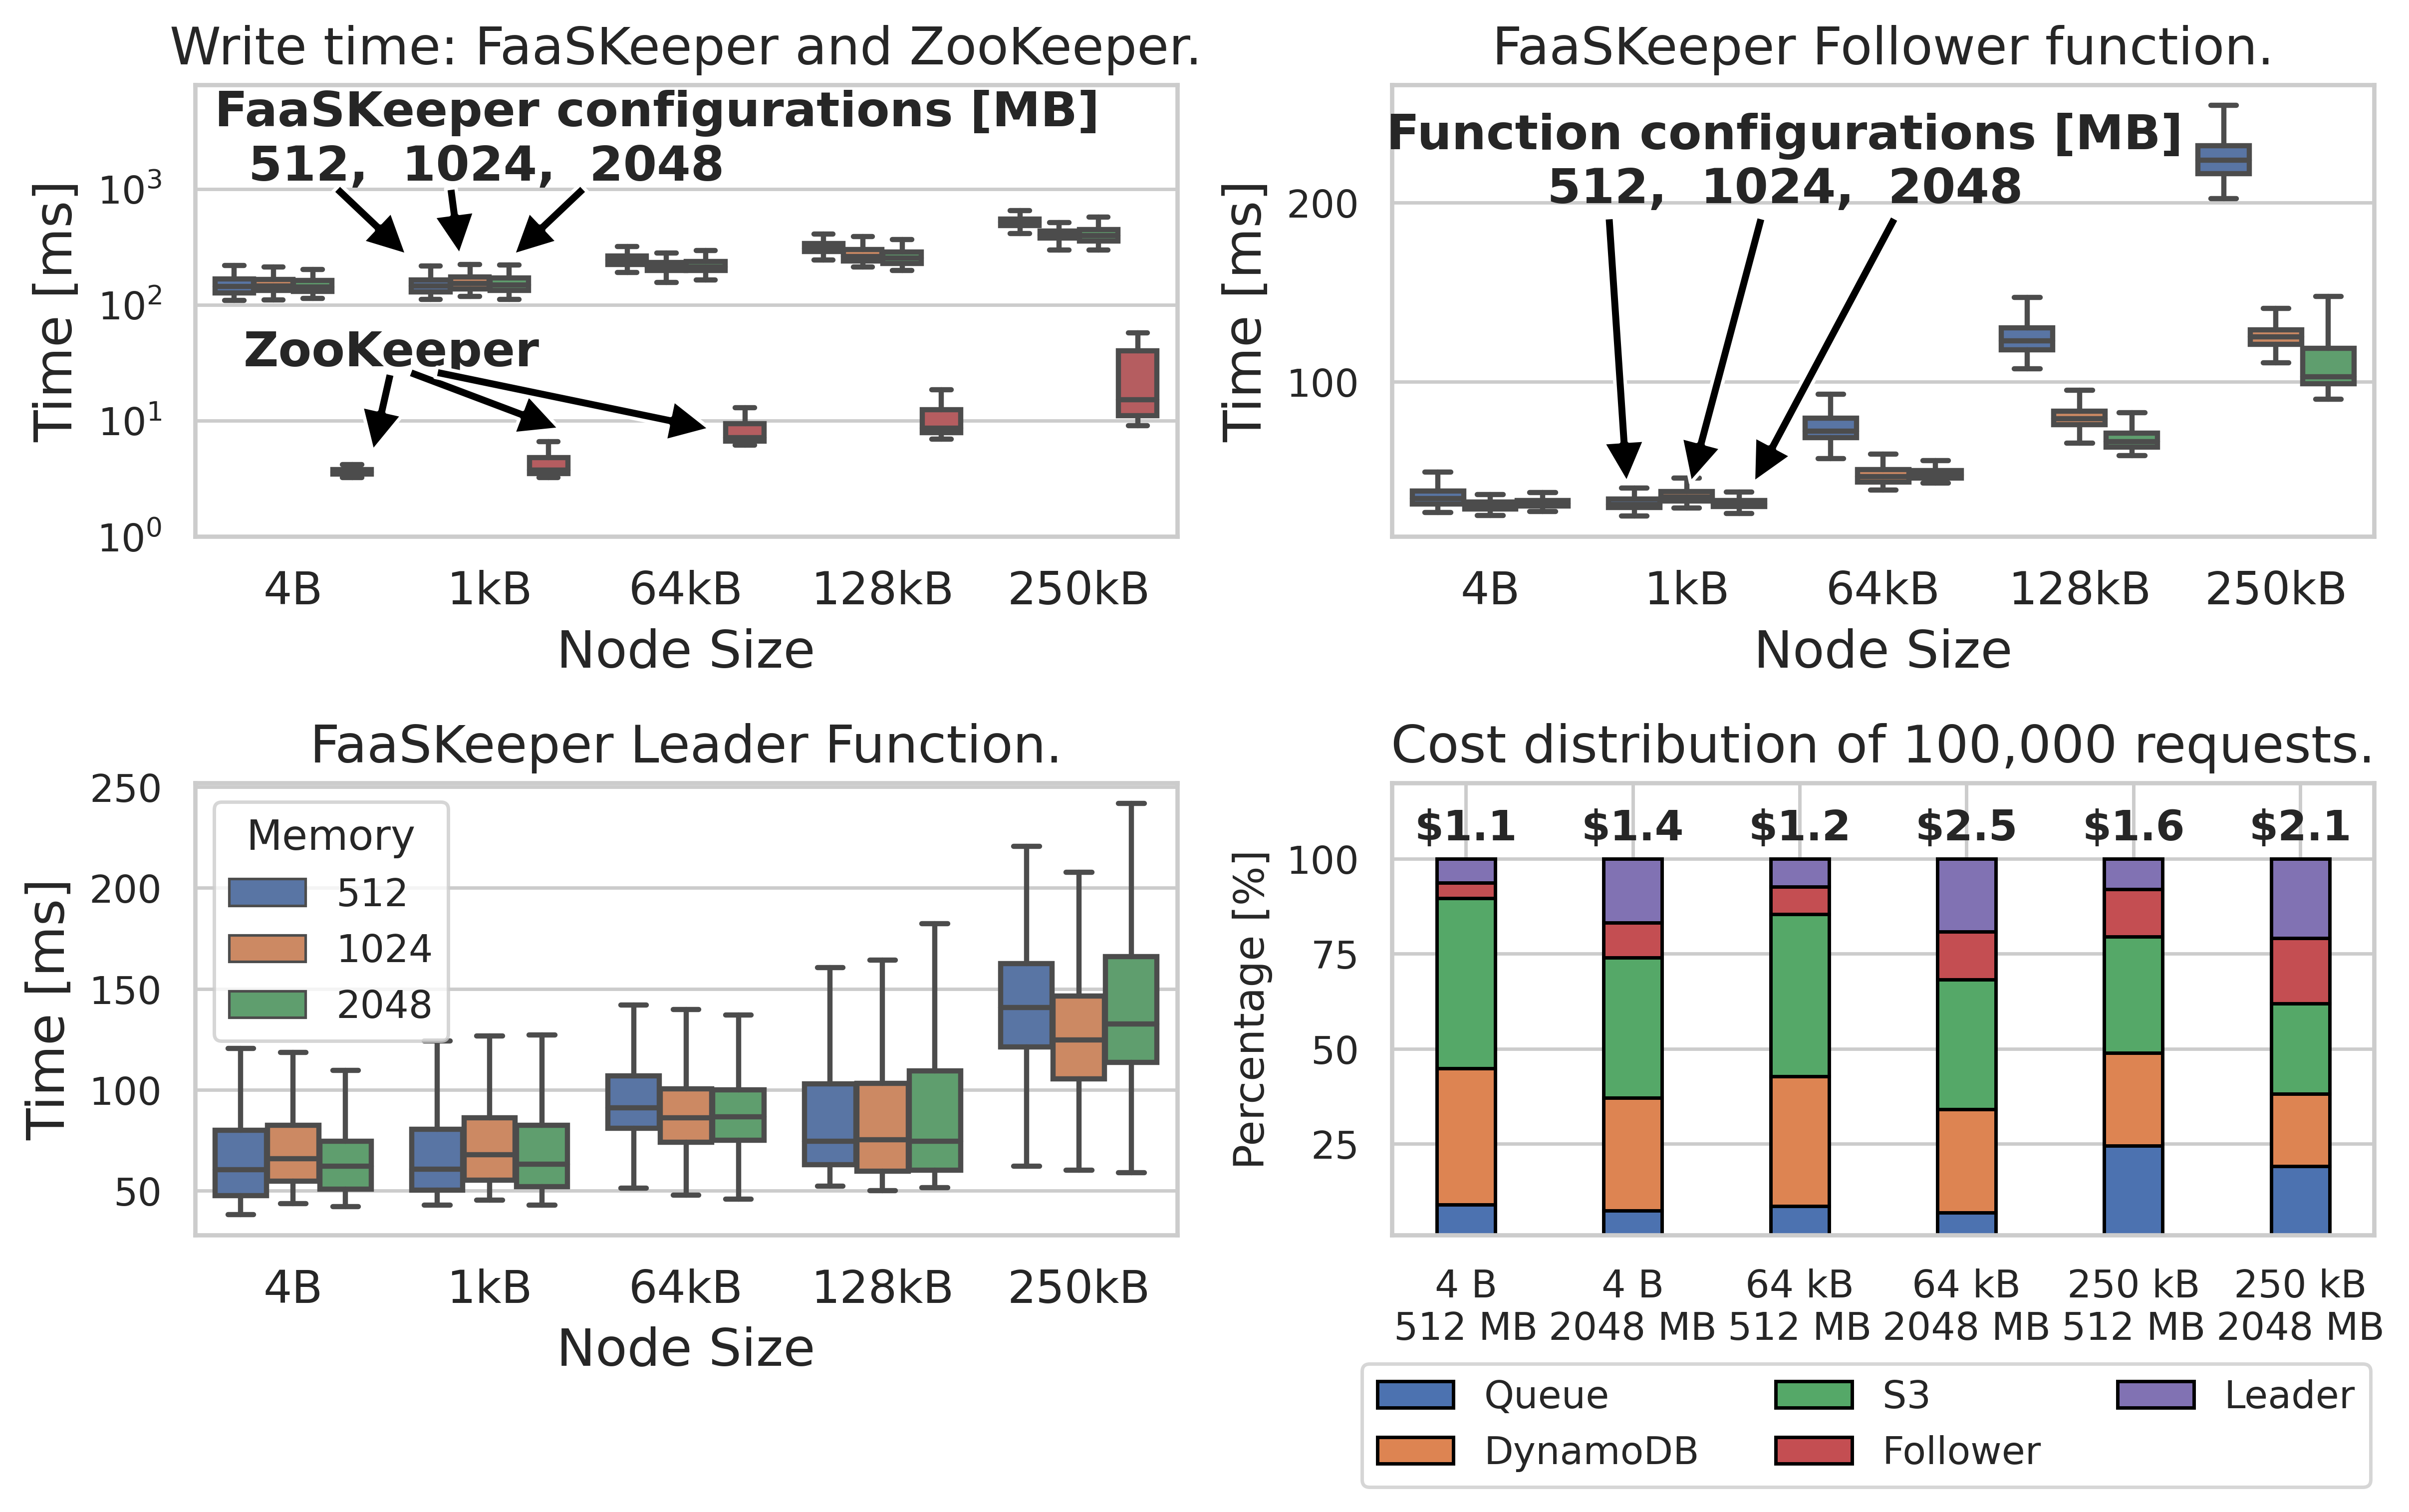

In [22]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from scipy import stats
from os.path import join, pardir
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

DATA_DIR = join(pardir, pardir, 'data', 'read')

#sns.set(rc={'figure.figsize':(16,8)})
sns.set(rc={'figure.figsize':(10,6.5)})
sns.set_style("whitegrid")

fig3 = plt.figure(constrained_layout=True)
gs = fig3.add_gridspec(2,4)
#writer1 = fig3.add_subplot(gs[0, 0:2])
#distr1 = fig3.add_subplot(gs[0, 2:4])
#total = fig3.add_subplot(gs[1, 0:2])
total = fig3.add_subplot(gs[0, 0:2])
writer1 = fig3.add_subplot(gs[0, 2:4])
distr1 = fig3.add_subplot(gs[1, 0:2])
total_cost = fig3.add_subplot(gs[1, 2:4])

# Draw a nested barplot by species and sex
dynamo_df.rename(columns={'memory': 'Memory'}, inplace=True)
#print(dynamo_df)
g = sns.boxplot(x="size", y="time",
            hue="Memory", #palette=["m", "g"],
            data=dynamo_df.loc[dynamo_df['function']=='writer'], ax=writer1,showfliers=False)

handles, labels = g.get_legend_handles_labels()
#g.legend().set_visible(False)
#(handles, [f"{m} MB" for m in labels], fontsize=7, ncol=2) #, bbox_to_anchor=(-0.03, -0.45), loc='lower center', handletextpad=0.4, fontsize=20)

g.set_xticklabels( ('4B', '1kB','64kB', '128kB', '250kB') )
g.set_xlabel('Node Size',fontsize=15)
g.set_ylabel('Time [ms]',fontsize=15)
g.set_title('FaaSKeeper Follower function.', fontsize=15)
g.tick_params(axis='x', labelsize=13)
#g.set_yscale('log')
g.legend().set_visible(False)

#for xtick in g.get_xticks():
#    print(xtick)
#    g.text(xtick,100,'100', horizontalalignment='center')#,size='x-small',color='w',weight='semibold')
                  #medians[xtick] + vertical_offset,medians[xtick], 
            #horizontalalignment='center',size='x-small',color='w',weight='semibold')

g.annotate('Function configurations [MB]\n512,  1024,  2048',fontweight='bold',
            xy=(1.5, 200), xytext=(1.5, 200), fontsize=14, ha='center')
g.annotate('', fontweight='bold',
            xy=(0.7, 35), xytext=(0.6, 200), fontsize=14,
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')
g.annotate('',
            xy=(1, 35), xytext=(1.4, 200), fontsize=12, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')
g.annotate('',
            xy=(1.3, 35), xytext=(2.1, 200), fontsize=12, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')

# Draw a nested barplot by species and sex
g = sns.boxplot(x="size", y="time",
            hue="Memory", #palette=["m", "g"],
            data=dynamo_df.loc[dynamo_df['function']=='distributor'], ax=distr1,showfliers=False)
handles, labels = g.get_legend_handles_labels()
#g.legend().set_visible(False)
g.tick_params(axis='x', labelsize=13)


#g.legend(handles, [f"{m} MB" for m in labels], fontsize=7, ncol=2) #, bbox_to_anchor=(-0.03, -0.45), loc='lower center', handletextpad=0.4, fontsize=20)
g.set_xticklabels( ('4B', '1kB','64kB', '128kB', '250kB') )
g.set_xlabel('Node Size',fontsize=15)
g.set_ylabel('Time [ms]',fontsize=15)
g.set_title('FaaSKeeper Leader Function.', fontsize=15)

#s3_df_client['data']/=1000.0
# Draw a nested barplot by species and sex
g = sns.boxplot(x="size", y="data",
            hue="memory", #palette=["m", "g"],
            data=dynamo_df_client.loc[dynamo_df_client['op']=='set_data'], ax=total,showfliers=False)
handles, labels = g.get_legend_handles_labels()

g.legend(handles, ['512 MB', '1024 MB', '2048 MB', 'ZooKeeper'], loc='upper left',ncol=2) #, bbox_to_anchor=(-0.03, -0.45), loc='lower center', handletextpad=0.4, fontsize=20)
g.set_xticklabels( ('4B', '1kB','64kB', '128kB', '250kB') )
g.set_xlabel('Node Size',fontsize=15)
g.set_ylabel('Time [ms]',fontsize=15)
g.set_title('Write time: FaaSKeeper and ZooKeeper.', fontsize=15)
g.set_yscale('log')
g.set_ylim(1, 8000)
g.legend().set_visible(False)
g.tick_params(axis='x', labelsize=13)


#g.annotate('Functions: 512 MB, 1024 MB\nand 2048 MB.',
#            xy=(0.7, 250), xytext=(0, 1000), fontsize=12, fontweight='bold',
#            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='left')
g.annotate('FaaSKeeper configurations [MB]\n  512,  1024,  2048', fontweight='bold',
            xy=(0, 1000), xytext=(-0.4, 1200), fontsize=14, ha='left')
g.annotate('',
            xy=(0.85, 250), xytext=(0.8, 1100), fontsize=14, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')
g.annotate('',
            xy=(1.1, 250), xytext=(1.5, 1100), fontsize=14, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')
g.annotate('',
            xy=(0.6, 250), xytext=(0.2, 1100), fontsize=14, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')

g.annotate('ZooKeeper', fontweight='bold',
            xy=(0, 1000), xytext=(0.5, 30), fontsize=14, ha='center')
g.annotate('',
            xy=(0.4, 5), xytext=(0.5, 28), fontsize=12, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')
g.annotate('',
            xy=(1.4, 8), xytext=(0.55, 28), fontsize=12, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')
g.annotate('',
            xy=(2.2, 8), xytext=(0.65, 28), fontsize=12, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')



width = 0.35       # the width of the bars: can also be len(x) sequence
sum_ = [0,0,0,0,0,0]
labels = ['4 B\n512 MB', '4 B\n2048 MB', '64 kB\n512 MB', '64 kB\n2048 MB', '250 kB\n512 MB', '250 kB\n2048 MB']
for id, col in enumerate(['Queue', 'DynamoDB', 'S3', 'Follower', 'Leader']):

    #print(barplot_data[id])
    total_cost.bar(labels, cost_data[id], width, label=col, bottom=sum_, edgecolor='black')
    sum_ = np.add(sum_, cost_data[id])
    
total_cost.legend(loc='upper left')
total_cost.set_ylabel('Percentage [%]')
total_cost.legend(bbox_to_anchor=(-0.05, -0.6), ncols=3,loc="lower left")
total_cost.annotate('$1.1', xy=(0.0, 105), ha='center', fontweight='bold')
total_cost.annotate('$1.4', xy=(1, 105), ha='center', fontweight='bold')
total_cost.annotate('$1.2', xy=(2, 105), ha='center', fontweight='bold')
total_cost.annotate('$2.5', xy=(3, 105), ha='center', fontweight='bold')
total_cost.annotate('$1.6', xy=(4, 105), ha='center', fontweight='bold')
total_cost.annotate('$2.1', xy=(5, 105), ha='center', fontweight='bold')
total_cost.set_ylim(1, 120)

total_cost.set_title('Cost distribution of 100,000 requests.', fontsize=15)

plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig("aws_write_performance_cost.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)

## Figure 10 - Hybrid Storage

In [24]:
import pandas as pd
import numpy as np
import os
from os.path import join, pardir
DATA_DIR = join(pardir, pardir, 'data', 'write_new_algorithm', 'keyvalue')
DATA_DIR_ZK = join(pardir, pardir, 'data', 'write_zookeeper')

dfs = []
dfs2 = []
for mem in [512, 1024, 2048]:
    
    for size in [4, 128, 256, 512, 1024,2048,4096]:
        df = pd.read_csv(join(DATA_DIR, f'persistent_{size}_{mem}_processed.csv'), index_col=0)
        df['size'] = size / 1024
        
        #print(df)
        # data is broken :-(
        #df = df.loc[df['memory'] == mem]
        #df = df.groupby(['memory', 'function']).head(150).reset_index(drop=True)
        #if df.shape[0] > 200:
        #    print(size, mem)
        dfs.append(df)
        
        
        zk = pd.read_csv(join(DATA_DIR, f'persistent_{size}_{mem}_processed.csv'), index_col=0)
        
        
        df = pd.read_csv(join(DATA_DIR, f'persistent_{size}_{mem}.csv'), index_col=0)
        #df = df.groupby(['memory', 'size']).head(100).reset_index(drop=True)
        df['size'] = size / 1024
        df['data'] /= 1000.0
        #df.loc[df['op'] == 'set_data', 'data'] /= 1000
        dfs2.append(df)
        
        
dynamo_df_hybrid = pd.concat(dfs)
dynamo_df_hybrid['system'] = 'persistent'
dynamo_df_client_hybrid = pd.concat(dfs2)
dynamo_df_client_hybrid['system'] = 'persistent'
print(dynamo_df)
print(dynamo_df_client)



                                   request     time  billed_time  Memory  \
0     30e78979-8d99-53ff-86cc-d5b4423de3e3    29.36           30     512   
1     32d32be1-a29f-5fbe-91fc-772c6d3bac42    38.95           39     512   
2     0312ed70-50ce-5b50-a571-b1bd9f6d96ed    37.46           38     512   
3     ecdcc4ec-a936-5825-ade7-98216695713a    35.09           36     512   
4     815f3e15-5baa-5387-98f7-62d894095a45    31.31           32     512   
...                                    ...      ...          ...     ...   
1023  e935f81e-e9e3-53b3-9606-a4d308e9a4c7   313.76          314    2048   
1024  00d51996-8abc-5544-add8-455b6bb651d8    82.72           83    2048   
1025  dc4f9900-06f9-532f-a8c8-c5cde7f050b7   137.01          138    2048   
1026  b5715f0a-d123-5391-9363-03c731c92b0b   195.76          196    2048   
1027  603a5d82-72aa-56ac-b102-014f9243de4d  1166.05         1167    2048   

      used_memory                                  read  write     function  \
0       

#### Cost data for hybrid

In [25]:
import numpy as np
import pandas as pd
import os
from os.path import join, pardir
DATA_DIR = join(pardir, pardir, 'data', 'write_new_algorithm/keyvalue')

dfs = []
for mem in [512, 1024, 2048]:
    
    for size in [4, 128, 256, 512, 1024,2048,4096]:
        df = pd.read_csv(join(DATA_DIR, f'persistent_{size}_{mem}_processed.csv'), index_col=0)
        df['size'] = size / 1024
        
        #print(df)
        # data is broken :-(
        #df = df.loc[df['memory'] == mem]
        #df = df.groupby(['memory', 'function']).head(150).reset_index(drop=True)
        #if df.shape[0] > 200:
        #    print(size, mem)
        dfs.append(df)
        
        
dynamo_df_hybrid = pd.concat(dfs)
dynamo_df_hybrid['system'] = 'persistent'
dynamo_df_hybrid['gbs'] = dynamo_df_hybrid['billed_time'] * dynamo_df_hybrid['memory'] / 1024.0 / 1000
#print(dynamo_df)
#print(dynamo_df.groupby(['function', 'memory', 'size']).median()['gbs'])
#for memory in [512, 1024, 2048]

data = {}
for f in ['writer', 'distributor']:
    data[f] = {}
    for m in [512, 1024, 2048]:
        data[f][m] = []

for name, group in dynamo_df_hybrid.groupby(['function', 'memory', 'size']):
    data[name[0]][name[1]].append(group['gbs'].median())
print(data)

import numpy as np
from sklearn.linear_model import LinearRegression

#r_sq = model.score(x, y)
#print('coefficient of determination:', r_sq)

coefficients = {}

sizes = np.array([4, 128, 256, 512, 1024,2048,4096],dtype=np.float64)
sizes /= 1024.0
x = sizes.reshape((-1, 1))
for f in ['writer', 'distributor']:
    coefficients[f] = {}
    for m in [512, 1024, 2048]:
        y = data[f][m]
        print(x, y)
        model = LinearRegression().fit(x, y)
        print(f, m, model.score(x, y))
        print(f, m, model.intercept_)
        print(f, m, model.coef_)
        coefficients[f][m] = (model.coef_[0], model.intercept_)

{'writer': {512: [0.0145, 0.01475, 0.0135, 0.015, 0.016, 0.0155, 0.0155], 1024: [0.03, 0.029, 0.029, 0.031, 0.032, 0.029, 0.033], 2048: [0.056, 0.064, 0.058, 0.062, 0.064, 0.064, 0.068]}, 'distributor': {512: [0.0135, 0.014, 0.0145, 0.015, 0.0155, 0.015, 0.0145], 1024: [0.026, 0.026, 0.024, 0.031, 0.027, 0.0265, 0.028], 2048: [0.052, 0.06, 0.068, 0.05, 0.056, 0.048, 0.056]}}
[[3.90625e-03]
 [1.25000e-01]
 [2.50000e-01]
 [5.00000e-01]
 [1.00000e+00]
 [2.00000e+00]
 [4.00000e+00]] [0.0145, 0.01475, 0.0135, 0.015, 0.016, 0.0155, 0.0155]
writer 512 0.29701735481537084
writer 512 0.014614405686246312
writer 512 [0.00031085]
[[3.90625e-03]
 [1.25000e-01]
 [2.50000e-01]
 [5.00000e-01]
 [1.00000e+00]
 [2.00000e+00]
 [4.00000e+00]] [0.03, 0.029, 0.029, 0.031, 0.032, 0.029, 0.033]
writer 1024 0.3908752069814163
writer 1024 0.029638301039986086
writer 1024 [0.00070211]
[[3.90625e-03]
 [1.25000e-01]
 [2.50000e-01]
 [5.00000e-01]
 [1.00000e+00]
 [2.00000e+00]
 [4.00000e+00]] [0.056, 0.064, 0.058, 0

In [26]:
import math
# PUT, COPY, POST, LIST requests (per 1,000 requests)
def write_s3(s):
    return  5*10**-6
def read_s3(s):
    return  0.4*10**-6
def write_dynamodb(s):
    return math.ceil(s) * 1.25 * 10**-6
def read_dynamodb(s):
    return math.ceil(s/4.0) * 0.25 * 10**-6
# FIFO Queues (per Million requests) 0.5
def sqs(s):
    return math.ceil(s/64.0) * 0.5 * 10**-6

lambda_const = 1.66667 * 10**-5

def writer(m, s):
    return lambda_const*(coefficients['writer'][m][0] * s + coefficients['writer'][m][1]) + 0.2 * 10**-6
def writer_time(m, s):
    return coefficients['writer'][m][0] * s + coefficients['writer'][m][1]

def distributor(m, s):
    #return lambda_const*(coefficients['distributor'][m][0] * s + coefficients['distributor'][m][1]) + 0.2 * 10**-6
    return lambda_const*(coefficients['distributor'][m][0] * s + coefficients['distributor'][m][1]) + 0.2 * 10**-6

def distributor_time(m, s):
    return coefficients['distributor'][m][0] * s + coefficients['distributor'][m][1]

def total_cost(m, s):
    #return 2 * sqs(s) + 3 * write_dynamodb(1) + read_dynamodb(1) + write_s3(s) + writer(m, s) + distributor(m, s)
    return 2 * sqs(s) + 3 * write_dynamodb(1) + read_dynamodb(1) + write_dynamodb(s) + writer(m, s) + distributor(m, s)


In [27]:
print(total_cost(2048, 4)*100000)
print(writer_time(2048, 4))
print(writer(2048, 4)*100000)
print(distributor(2048, 4)*100000)

1.2419387902206003
0.06850878947970604
0.13418154416214167
0.10775724605845867


In [28]:

cost_data = [[], [], [], [], []]

# queue
# DynamoDB ops
# S3 write
# Writer
# Distributor
requests = 10**5

#sizes = np.array([4, 128, 256, 512, 1024,2048,4096],dtype=np.float64)
#sizes /= 1024.0

sizes = np.array([4, 128, 512, 1024, 4096],dtype=np.float64)
sizes /= 1024.0

sums_prices = {}

#print(len(sizes))
for size in sizes:
    
    for memory in [512,  2048]:
        
        #print(size, memory, cost_data,2 * sqs(size) * requests)
        cost_data[0].append( 2 * sqs(size) * requests )
        cost_data[1].append( (3 * write_dynamodb(1) + read_dynamodb(1))* requests  )
        cost_data[2].append( write_dynamodb(size) * requests )
        cost_data[3].append( writer(memory, size) * requests )
        cost_data[4].append( distributor(memory, size)* requests )
        
        
        #print(size, memory, 2 * sqs(size) * requests , (3 * write_dynamodb(1) + read_dynamodb(1))* requests ,write_s3(size) * requests,writer(memory, size) * requests,distributor(memory, size) * requests)
        
        sum_ = 0
        for i in range(5):
            sum_ += cost_data[i][-1]
        for i in range(5):
            cost_data[i][-1] = cost_data[i][-1] / sum_ *100
        sums_prices[(size, memory)] = round(sum_, 1)
        print(size, memory, round(sum_, 1))
        
print(cost_data)

0.00390625 512 0.7
0.00390625 2048 0.9
0.125 512 0.7
0.125 2048 0.9
0.5 512 0.7
0.5 2048 0.9
1.0 512 0.7
1.0 2048 0.9
4.0 512 1.1
4.0 2048 1.2
[[14.017342248763832, 11.633183177248029, 14.01559393193904, 11.630178441347578, 14.010182554917023, 11.620883291014392, 14.002973882303305, 11.608512844870688, 9.163058327696692, 8.051926615661746], [56.06936899505533, 46.532732708992114, 56.06237572775616, 46.52071376539031, 56.04073021966809, 46.48353316405757, 56.01189552921322, 46.43405137948275, 36.65223331078677, 32.20770646264698], [17.521677810954788, 14.541478971560034, 17.5194924149238, 14.537723051684473, 17.51272819364628, 14.52610411376799, 17.503717352879132, 14.51064105608836, 45.815291638483465, 40.259633078308724], [6.218011061306662, 13.932189771672881, 6.2260284582500045, 13.979408249286983, 6.25084384467222, 14.125478607038444, 6.283901233904719, 14.319876269151033, 4.254383319622372, 10.804199467697407], [6.17359988391941, 13.360415370526951, 6.176509467130997, 13.331976492

#### Plot for hybrid

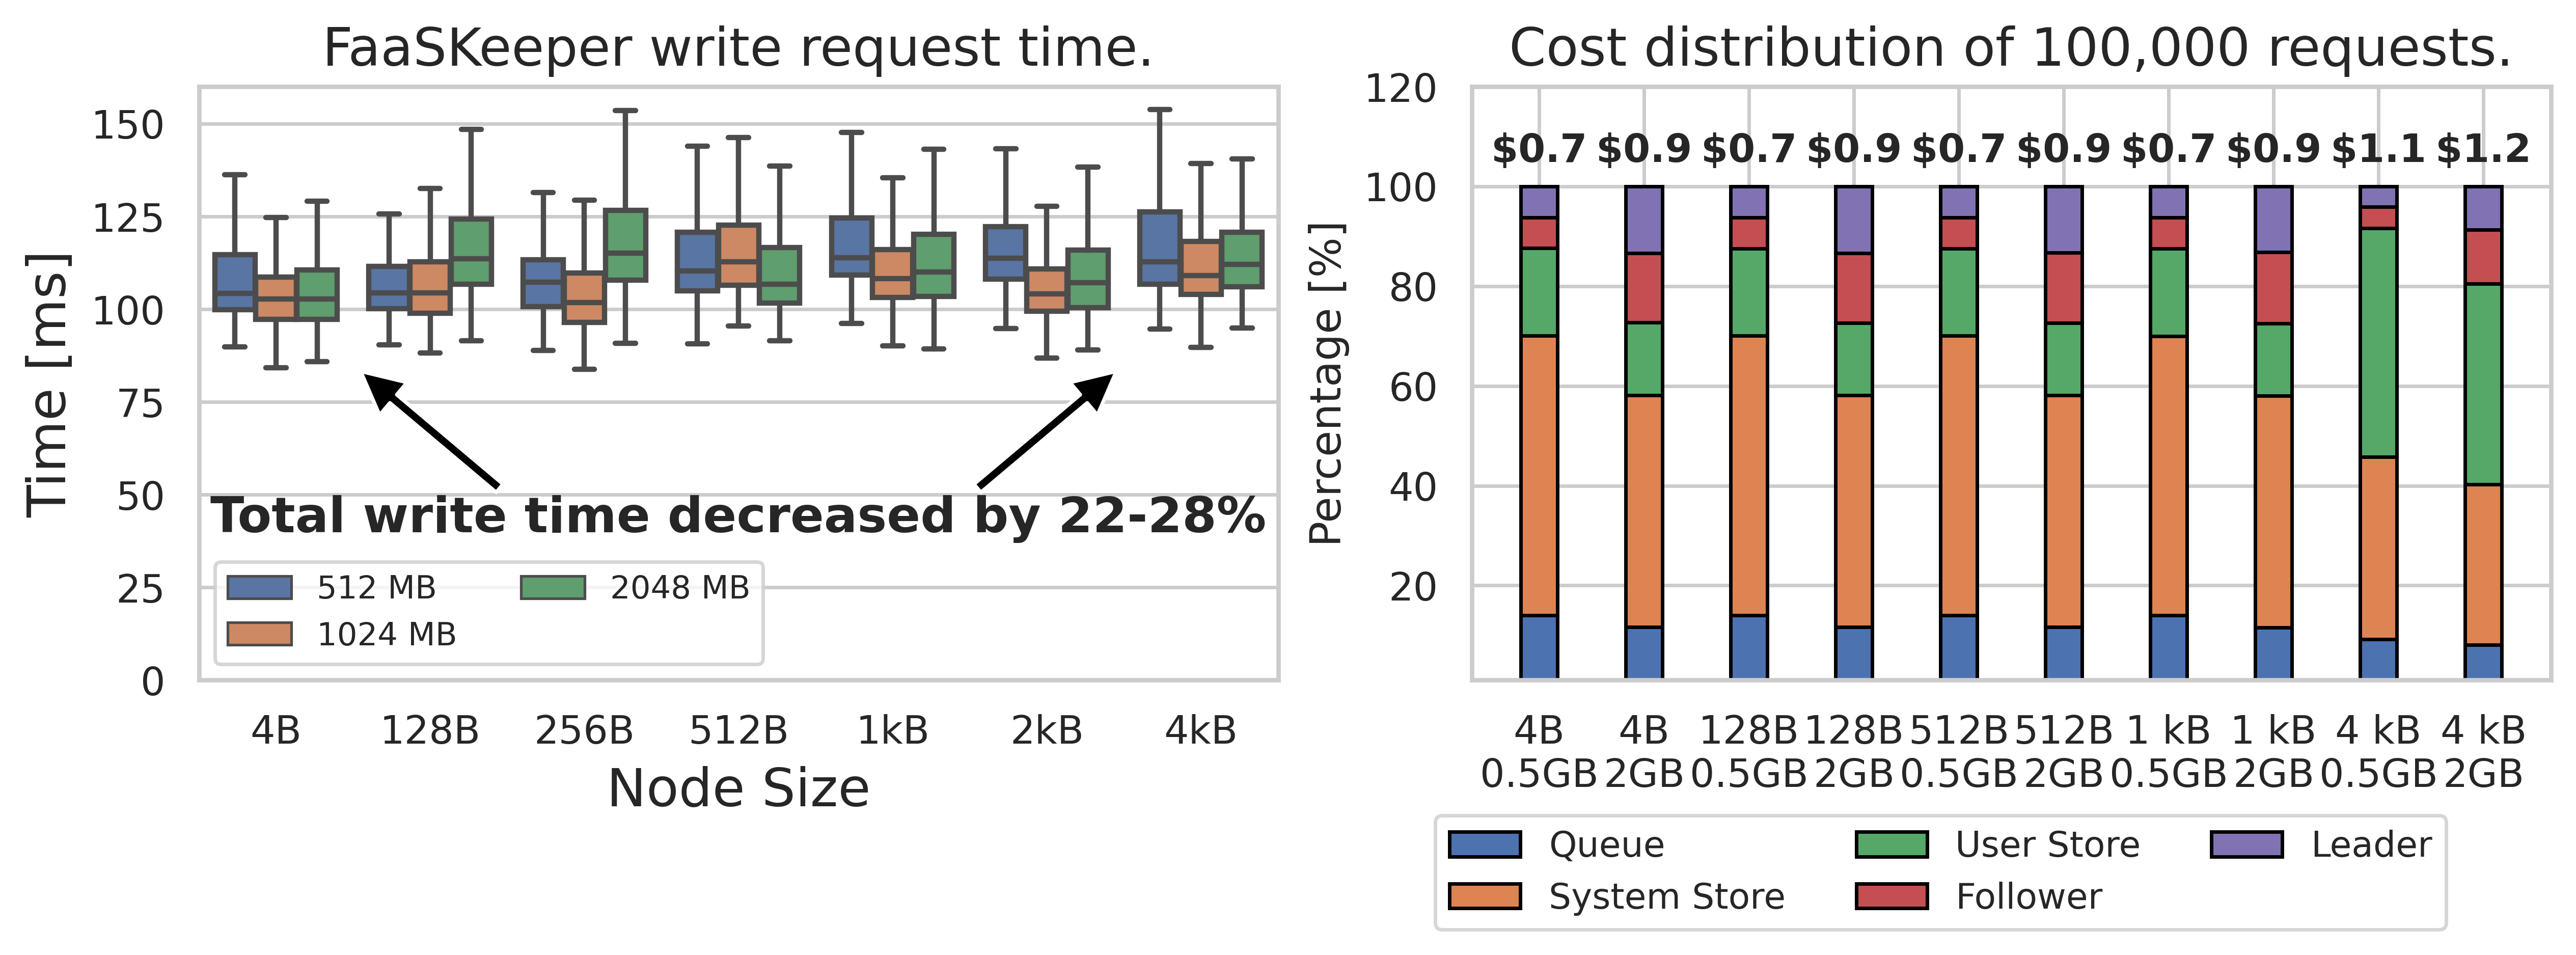

In [29]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from scipy import stats
from os.path import join, pardir

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

DATA_DIR = join(pardir, pardir, 'data', 'read')

#sns.set(rc={'figure.figsize':(16,8)})
#sns.set(rc={'figure.figsize':(10,3)})
sns.set(rc={'figure.figsize':(10,3.5)})
sns.set_style("whitegrid")

fig3 = plt.figure(constrained_layout=True)
gs = fig3.add_gridspec(1,4)
barplot = fig3.add_subplot(gs[0,0:2])
total_cost = fig3.add_subplot(gs[0,2:4])


g = sns.boxplot(x="size", y="data",
            hue="memory", #palette=["m", "g"],
            data=dynamo_df_client_hybrid.loc[dynamo_df_client_hybrid['op']=='set_data'], ax=barplot,showfliers=False)
g.set_xticklabels( ('4B', '128B', '256B', '512B', '1kB', '2kB', '4kB') )
g.set_xlabel('Node Size',fontsize=15)
g.set_ylabel('Time [ms]',fontsize=15)
g.set_ylim(0, 160)

handles, labels = g.get_legend_handles_labels()
g.legend(handles, [f"{m} MB" for m in labels], fontsize=9, ncol=2) #, bbox_to_anchor=(-0.03, -0.45), loc='lower center', handletextpad=0.4, fontsize=20)
g.set_title('FaaSKeeper write request time.', fontsize=15)


g.annotate('Total write time decreased by 22-28%',fontweight='bold',
            xy=(1.5, 50), xytext=(3, 40), fontsize=14, ha='center')
g.annotate('', fontweight='bold',
            xy=(0.5, 85), xytext=(1.5, 50), fontsize=14,
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')
g.annotate('',
            xy=(5.5, 85), xytext=(4.5, 50), fontsize=12, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')

width = 0.35       # the width of the bars: can also be len(x) sequence
#sum_ = [0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#labels = ['4 B\n512 MB', '4 B\n2048 MB','128 B\n512 MB', '128 B\n2048 MB',  
#          '256 B\n512 MB', '256 B\n2048 MB', '512 kB\n512 MB', '512 kB\n2048 MB',
#          '1 kB\n512 MB', '1 kB\n2048 MB', '2 kB\n512 MB', '2 kB\n2048 MB',
#          '4 kB\n512 MB', '4 kB\n2048 MB'
#]
sum_ = [0,0,0,0,0,0,0,0,0,0]
labels = ['4B\n0.5GB', '4B\n2GB','128B\n0.5GB', '128B\n2GB',  
          '512B\n0.5GB', '512B\n2GB',
          '1 kB\n0.5GB', '1 kB\n2GB',
          '4 kB\n0.5GB', '4 kB\n2GB'
]
for id, col in enumerate(['Queue', 'System Store', 'User Store', 'Follower', 'Leader']):

    total_cost.bar(labels, cost_data[id], width, label=col, bottom=sum_, edgecolor='black')
    sum_ = np.add(sum_, cost_data[id])

total_cost.legend(loc='upper left')
total_cost.set_ylabel('Percentage [%]')
#total_cost.legend(bbox_to_anchor=(-0.05, -0.6), ncols=3,loc="lower left",fontsize=10)
total_cost.legend(bbox_to_anchor=(-0.05, -0.45), ncols=3,loc="lower left",fontsize=10)

sizes = np.array([4, 128, 512, 1024, 4096],dtype=np.float64)
sizes /= 1024.0
cnt = 0
for i in range(5):
    
    for j in [512,2048]:
        d = sums_prices[(sizes[i], j)]
        total_cost.annotate(f'${d}', xy=(cnt, 105), ha='center', fontweight='bold', fontsize=11)
        cnt+= 1

total_cost.set_ylim(1, 120)
total_cost.set_title('Cost distribution of 100,000 requests.', fontsize=15)

#width = 0.35       # the width of the bars: can also be len(x) sequence
#sum_ = [0,0,0,0,0,0]
#labels = ['4 B\n512 MB', '4 B\n2048 MB', '64 kB\n512 MB', '64 kB\n2048 MB', '250 kB\n512 MB', '250 kB\n2048 MB']
#for id, col in enumerate(['Lock Node', 'Commit and Unlock', 'Push to Distributor', 'Other']):#

#    print(barplot_data_writer[id])
#    barplot.bar(labels, barplot_data_writer[id], width, label=col, bottom=sum_, edgecolor='black')
#    sum_ = np.add(sum_, barplot_data_writer[id])
#barplot.legend()

#barplot.set_title('Writer function: time distribution.', fontsize=15)


#width = 0.35       # the width of the bars: can also be len(x) sequence
#sum_ = [0,0,0,0,0,0]
#labels = ['4 B\n512 MB', '4 B\n2048 MB', '64 kB\n512 MB', '64 kB\n2048 MB', '250 kB\n512 MB', '250 kB\n2048 MB']
#for id, col in enumerate(['Update User Storage', 'Pop Updates', 'Query Watches', 'Notify Client', 'Other']):

    #print(barplot_data[id])
#    barplot_distr.bar(labels, barplot_data_distributor[id], width, label=col, bottom=sum_, edgecolor='black')
#    sum_ = np.add(sum_, barplot_data_distributor[id])
#barplot_distr.legend(loc='upper left')
#barplot_distr.set_ylim(1, 200)

#barplot_distr.set_title('Distributor function: time distribution.', fontsize=15)

#plt.rcParams['figure.dpi'] = 500
#plt.tight_layout()
plt.savefig("aws_write_performance_cost_hybrid.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)

In [41]:
classic_times = dynamo_df_client.loc[
    (dynamo_df_client['op']=='set_data') & ~(dynamo_df_client['memory']=='ZooKeeper')
].groupby(['memory', 'size'])['data'].median().reset_index()

In [36]:
hybrid_times = dynamo_df_client_hybrid.loc[
    (dynamo_df_client_hybrid['op']=='set_data') & ~(dynamo_df_client_hybrid['memory']=='ZooKeeper')
].groupby(['memory', 'size'])['data'].median().reset_index()

In [37]:
for size in [0.003906, 1.0]:
    for memory in [512, 2048]:
        classic = classic_times.loc[(classic_times['memory'] == memory) & (classic_times['size'] == size)]['data'].values[0]
        hybrid = hybrid_times.loc[(hybrid_times['memory'] == memory) & (hybrid_times['size'] == size)]['data'].values[0]
        print(size, memory, classic, hybrid)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [38]:
print(classic_times)
print(hybrid_times)
print(512, 4, 1 - 104.2290/144.3880)
print(512, 1024, 1 - 113.8965/146.0305)
print(2048, 4, 1 - 102.7970/143.5850)
print(2048, 1024, 1 - 110.0745/149.3365)

    memory        size      data
0      512    0.003906  144.3880
1      512    1.000000  146.0305
2      512   64.000000  243.9190
3      512  128.000000  308.7215
4      512  250.000000  518.9910
5     1024    0.003906  145.7575
6     1024    1.000000  154.3290
7     1024   64.000000  212.1795
8     1024  128.000000  263.6095
9     1024  250.000000  401.7390
10    2048    0.003906  143.5850
11    2048    1.000000  149.3365
12    2048   64.000000  213.2815
13    2048  128.000000  253.9850
14    2048  250.000000  398.8990
    memory      size      data
0      512  0.003906  104.2290
1      512  0.125000  104.3820
2      512  0.250000  107.2845
3      512  0.500000  110.3330
4      512  1.000000  113.8965
5      512  2.000000  113.7165
6      512  4.000000  112.7975
7     1024  0.003906  102.7840
8     1024  0.125000  104.4740
9     1024  0.250000  101.8700
10    1024  0.500000  112.8490
11    1024  1.000000  108.2980
12    1024  2.000000  104.1390
13    1024  4.000000  109.1225
14    2

# GCP

In [45]:
DATA_DIR = join(pardir, pardir, 'data', 'write_new_algorithm', 'gcp_cloud_storage')
dfs = []
import ast
# lock atomic commit push rest
#barplot_data = [[],[],[],[],[]]
#barplot_stds = [[],[],[],[],[],[]]
#for size in [4, 1024, 65536, 131072, 256000]:


full_data = []
for size in [4, 65536, 262144]:
    
    for memory in [512, 2048]:
    #for memory in [512]:
        
        with open(join(DATA_DIR, f'persistent_{size}_{memory}.timings')) as in_f:
                  
            writer = False
            for line in in_f:
                
                #print(line.split(':')[2])
                key = line.split(':')[1].split()[0].strip()
                if key == 'total':
                    key = f'{key}_writer' if not writer else f'{key}_distributor'
                    writer = True
                data = ast.literal_eval(line.split(':')[2])
                for val in data:
                    full_data.append([int(size), int(memory), key, val])
        

timings_df = pd.DataFrame(data=full_data, columns=['size', 'memory', 'key', 'value']) 
timings_df['value'] *= 1000
print(timings_df['key'].unique())
#size = 4
#memory = 512
#df = pd.read_csv(join(DATA_DIR, f'persistent_{size}_summary.csv'),index_col=None)
#df['size'] = size / 1024.0
#df['value'] *= 1000.0
#df['value'] /= df['repetitions']
#print(df.loc[(df['memory'] == memory) & (df['function'] == 'writer')])

#barplot_data[0].append(df.loc[(df['memory'] == memory) & (df['function'] == 'writer') & (df['type'] == 'lock')]['value'].values[0])
#barplot_data[1].append(df.loc[(df['memory'] == memory) & (df['function'] == 'writer') & (df['type'] == 'atomic')]['value'].values[0])
#barplot_data[2].append(df.loc[(df['memory'] == memory) & (df['function'] == 'writer') & (df['type'] == 'commit')]['value'].values[0])
#barplot_data[3].append(df.loc[(df['memory'] == memory) & (df['function'] == 'writer') & (df['type'] == 'push')]['value'].values[0])
#total = df.loc[(df['memory'] == memory) & (df['function'] == 'writer') & (df['type'] == 'total')]['value'].values[0]
#barplot_data[4].append(
#    total
#    - barplot_data[0][-1] - barplot_data[1][-1] - barplot_data[2][-1] - barplot_data[3][-1]
#)
barplot_data_writer = [[],[],[]]


#for size in [4, 65536, 256000]:
for size in [4, 65536, 262144]:
    
    for memory in [512, 2048]:
        
        barplot_data_writer[0].append(
            timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'lock')]['value'].median()
        )
        #barplot_data_writer[1].append(timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size)& (timings_df['key'] == 'commit')]['value'].median())
        barplot_data_writer[1].append(timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size)& (timings_df['key'] == 'push')]['value'].median())

        total = timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size)& (timings_df['key'] == 'total_writer')]['value'].median()
        #print(total)
        barplot_data_writer[2].append(
            total
            - barplot_data_writer[0][-1] - barplot_data_writer[1][-1] #- barplot_data_writer[2][-1]
        )
        
barplot_data_distributor = [[],[],[],[],[],[]]


#for size in [4, 65536, 256000]:
for size in [4, 65536, 262144]:
    
    for memory in [512, 2048]:
        
        #barplot_data_distributor[0].append(
        #    #timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'exec_read')]['value'].median()
        #    + timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'commit')]['value'].median()
        #    + timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'exec_update')]['value'].median()
        #)
        barplot_data_distributor[0].append(
            #timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'exec_read')]['value'].median()
            timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'commit')]['value'].median()
        )
        barplot_data_distributor[1].append(
            + timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'exec_update')]['value'].median()
        )
        #barplot_data_distributor[1].append(
        #    timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'exec_update')]['value'].median()
        #)
        barplot_data_distributor[2].append(
            timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'exec_pop_updates')]['value'].median()
        )
        barplot_data_distributor[3].append(timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size)& (timings_df['key'] == 'watch_query')]['value'].median())
        barplot_data_distributor[4].append(timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size)& (timings_df['key'] == 'notify')]['value'].median())

        total = timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size)& (timings_df['key'] == 'total_distributor')]['value'].median()
        #print(total)
        barplot_data_distributor[5].append(
            total
            - barplot_data_distributor[0][-1] - barplot_data_distributor[1][-1] - barplot_data_distributor[2][-1] - barplot_data_distributor[3][-1]- barplot_data_distributor[4][-1]
        )

['lock' 'push' 'total_writer' 'parse' 'write' 'watch_query' 'notify'
 'total_distributor' 'exec_update' 'exec_pop_updates' 'commit']


[88.09828758239746, 85.49082279205322, 97.95141220092773, 82.5650691986084, 85.24036407470703, 90.87753295898438]
[0.5898475646972656, 0.5775690078735352, 0.8922815322875977, 0.9024143218994141, 3.4426450729370117, 3.592252731323242]
[0.44715404510498047, 0.20933151245117188, 1.5020370483398438, 1.9631385803222656, 6.047964096069336, 7.1048736572265625]


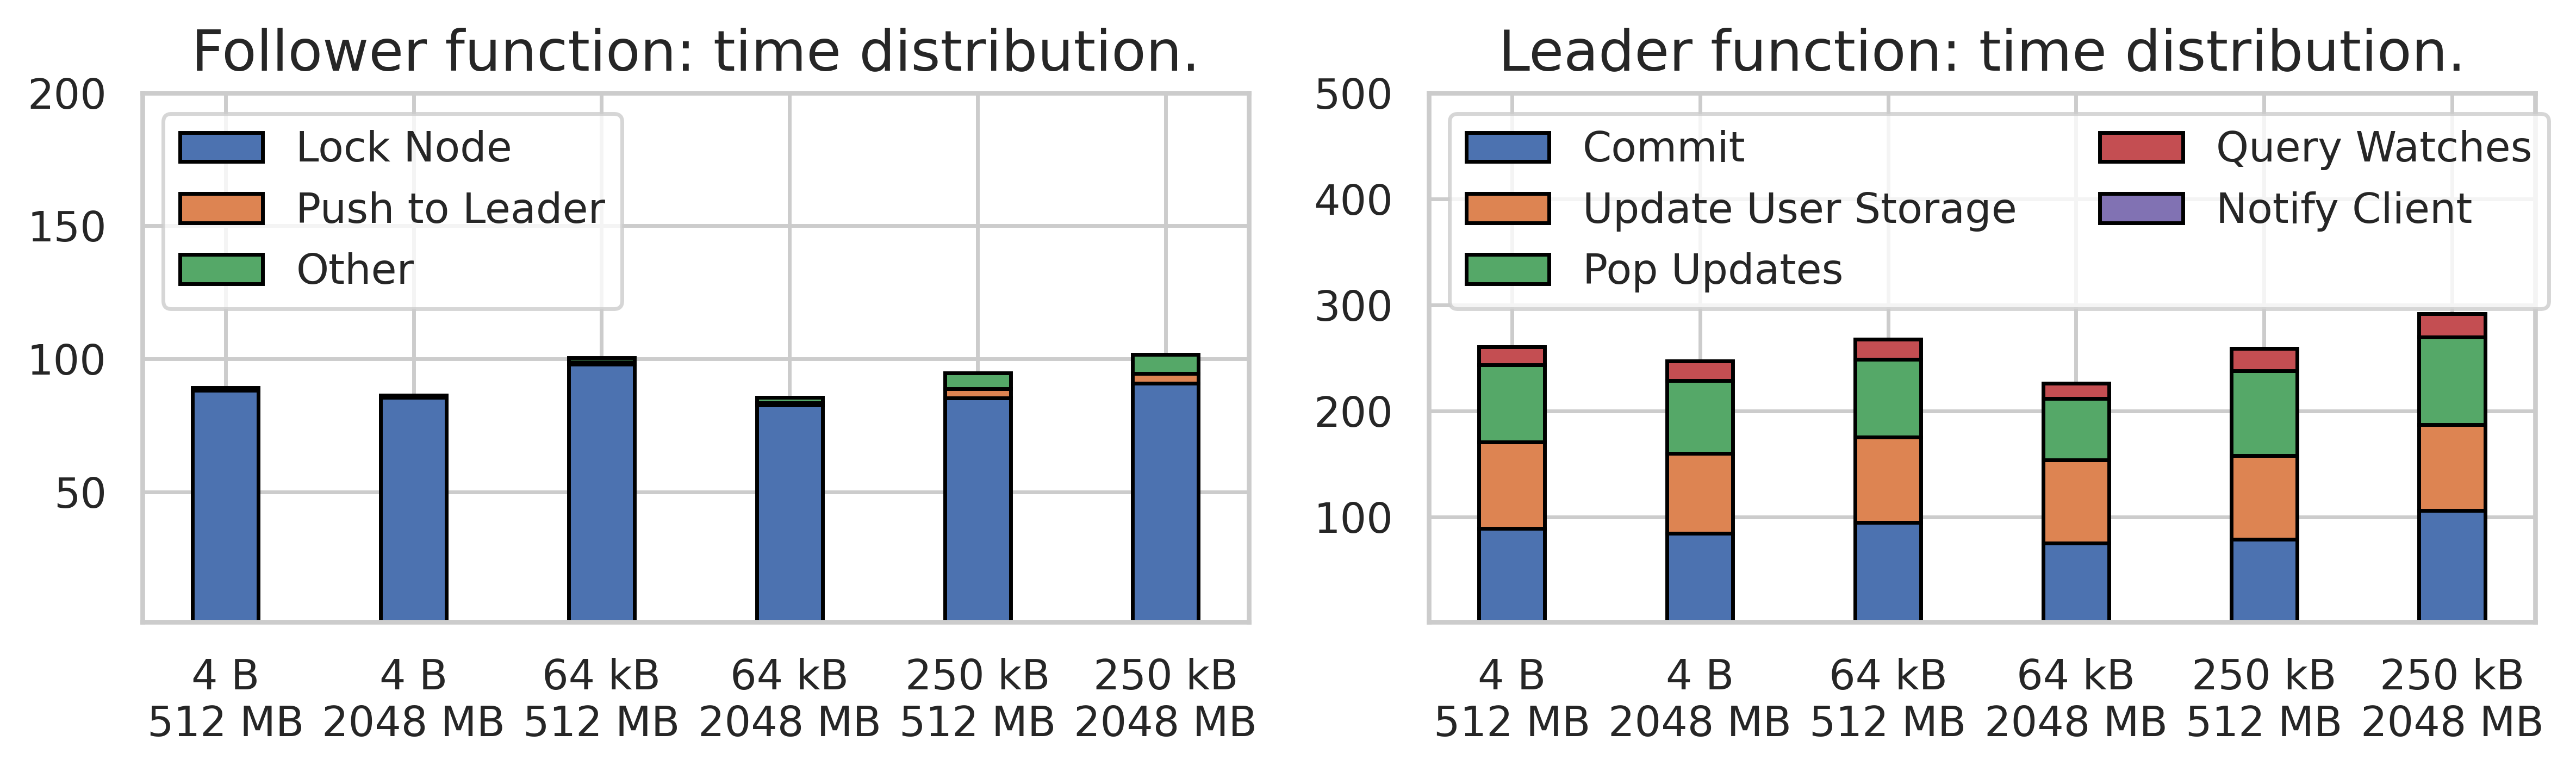

In [46]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from scipy import stats
from os.path import join, pardir
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

DATA_DIR = join(pardir, pardir, 'data', 'read')

#sns.set(rc={'figure.figsize':(16,8)})
sns.set(rc={'figure.figsize':(10,3)})
sns.set_style("whitegrid")

fig3 = plt.figure(constrained_layout=True)
gs = fig3.add_gridspec(1,4)
barplot = fig3.add_subplot(gs[0,0:2])
barplot_distr = fig3.add_subplot(gs[0,2:4])

width = 0.35       # the width of the bars: can also be len(x) sequence
sum_ = [0,0,0,0,0,0]
labels = ['4 B\n512 MB', '4 B\n2048 MB', '64 kB\n512 MB', '64 kB\n2048 MB', '250 kB\n512 MB', '250 kB\n2048 MB']
#for id, col in enumerate(['Lock Node', 'Commit and Unlock', 'Push to Distributor', 'Other']):
for id, col in enumerate(['Lock Node', 'Push to Leader', 'Other']):

    print(barplot_data_writer[id])
    barplot.bar(labels, barplot_data_writer[id], width, label=col, bottom=sum_, edgecolor='black')
    sum_ = np.add(sum_, barplot_data_writer[id])
barplot.legend()

barplot.legend(loc='upper left')
barplot.set_ylim(1, 200)
barplot.set_title('Follower function: time distribution.', fontsize=15)


width = 0.35       # the width of the bars: can also be len(x) sequence
sum_ = [0,0,0,0,0,0]
labels = ['4 B\n512 MB', '4 B\n2048 MB', '64 kB\n512 MB', '64 kB\n2048 MB', '250 kB\n512 MB', '250 kB\n2048 MB']
#for id, col in enumerate(['Update User Storage', 'Pop Updates', 'Query Watches', 'Notify Client', 'Other']):
for id, col in enumerate(['Commit', 'Update User Storage', 'Pop Updates', 'Query Watches', 'Notify Client']):


    #print(barplot_data[id])
    barplot_distr.bar(labels, barplot_data_distributor[id], width, label=col, bottom=sum_, edgecolor='black')
    sum_ = np.add(sum_, barplot_data_distributor[id])
barplot_distr.legend(loc='upper left',ncol=2)
barplot_distr.set_ylim(1, 500)

barplot_distr.set_title('Leader function: time distribution.', fontsize=15)

plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig("write_distribution_gcp.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)